## Augmented LLM

An important architectural distinction between workflows and agents:
- Workflows are systems where LLMs and tools are orchestrated through predefined code paths.
- Agents, on the other hand, are systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks.

Augmented LLMs combine the generative power of traditional LLMs with external systems to create more reliable, dynamic, and capable AI assistants.

The basic building block of agentic systems is an LLM enhanced with augmentations such as retrieval, tools, and memory. Our current models can actively use these capabilities—generating their own search queries, selecting appropriate tools, and determining what information to retain.

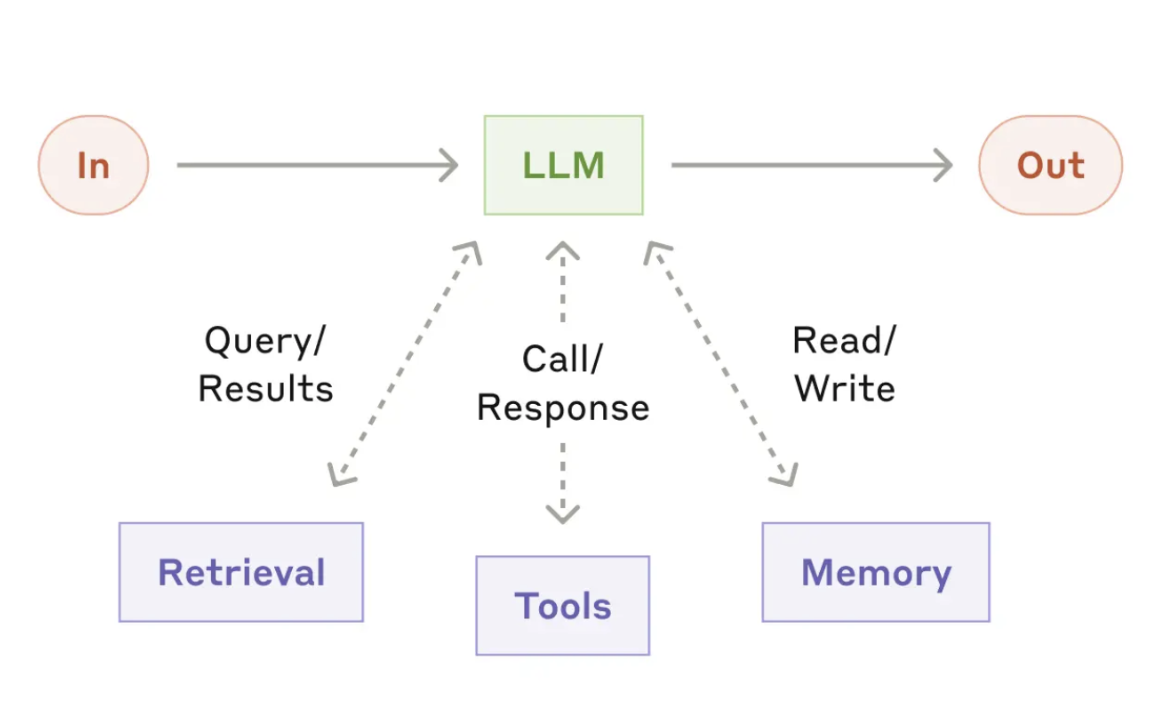

In [7]:
from IPython.display import Image
Image(filename='images/image.png', width=600, height=600)

In [21]:
import os
from dotenv import load_dotenv
load_dotenv()

# OpenAI API key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [22]:
# LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="o4-mini", openai_api_key=OPENAI_API_KEY)

In [24]:
# Schema for structured output
from pydantic import BaseModel, Field
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optmized web search")
    justification: str = Field(None, description="Why this query is relevant to the user's request")

# Augment the LLM with a schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output.search_query)
print(output.justification)

coronary artery calcium score correlation with LDL cholesterol levels
To find studies examining how coronary artery calcium scores relate to high cholesterol (particularly LDL), revealing their association and clinical implications.


In [26]:
# Define a tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

# Augment the LLM with a tool
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 3 times 4?")
# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 3, 'b': 4},
  'id': 'call_DrSkrd8mlf0WyxJleeM8u5zL',
  'type': 'tool_call'}]

### Prompt Chaining

Prompt chaining is a technique where multiple prompts are sequentially linked to guide a Large Language Model (LLM) through a complex task by breaking it into smaller, manageable steps. Instead of relying on a single, monolithic prompt, each step builds on the previous output, improving accuracy, coherence, and control over the LLM's responses.

Prompt Chaining vs. Single Prompt

| Feature	| Single Prompt	| Prompt Chaining |
| --- | --- | --- |
| Complexity	| Limited	| Handles multi-step tasks |
| Accuracy	| Prone to errors	| Self-correcting |
| Control	| Low	| High (per-step tweaks)| 
| Use Case	| Simple Q&A	| Coding, analysis, agents |

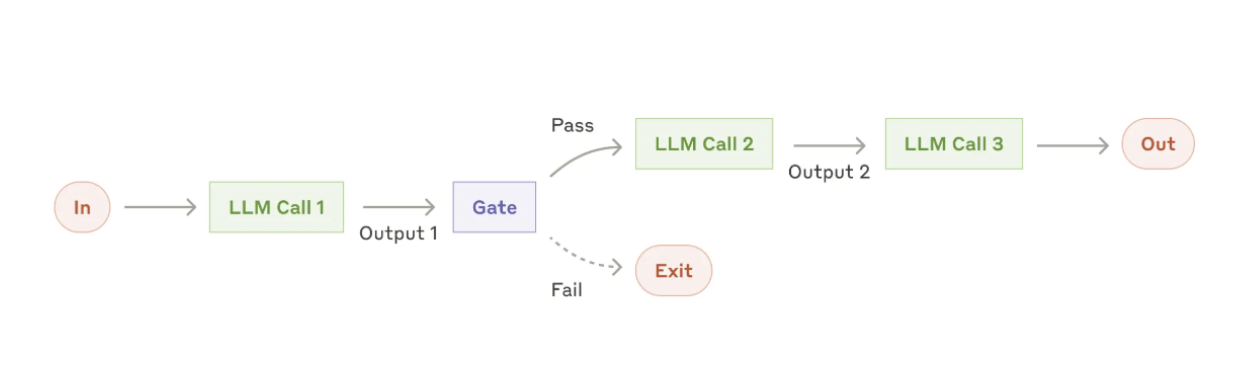

In [27]:
Image(filename='images/prompt_chaining.png', width=800, height=600)

**When to use this workflow:** This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

In [38]:
from typing_extensions import TypedDict

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [39]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

# Conditional edge function to check if the joke has a punchline
def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

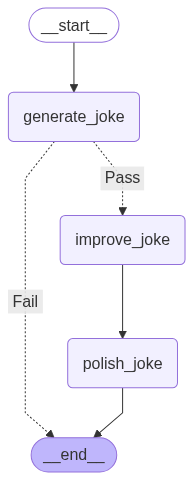

In [40]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [42]:
state = chain.invoke({"topic": "Palmeira não tem mundial"})
print("Initial Joke:", state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved Joke:", state["improved_joke"])
    print("\n--- --- ---\n")
    print("Final Joke:", state["final_joke"])
else:
    print("Tsc tsc tsc - no punchline!")

Initial Joke: Por que o Palmeiras não tem Mundial?  
Porque nem o GPS acha onde fica o troféu!

--- --- ---

Improved Joke: Por que o Palmeiras não tem Mundial?  
Porque nem o GPS acha onde fica o troféu – toda vez que digita “Mundial” ele responde: “Rota não encontrada!”

--- --- ---

Final Joke: Por que o Palmeiras não tem Mundial?  
Porque nem o GPS acha onde fica o troféu – toda vez que digita “Mundial” ele responde: “Rota não encontrada!”  

Mas olha só o plot twist: na última atualização o GPS finalmente deu sinal de vida… e indicou uma rota até o sítio do presidente do clube. Chegando lá, descobriram que o “troféu” estava enterrado no jardim de inverno, virando estufa de samambaias! 🚩🌱


### Parallelization

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations:

- Sectioning: Breaking a task into independent subtasks run in parallel.
- Voting: Running the same task multiple times to get diverse outputs.

**When to use this workflow:** Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

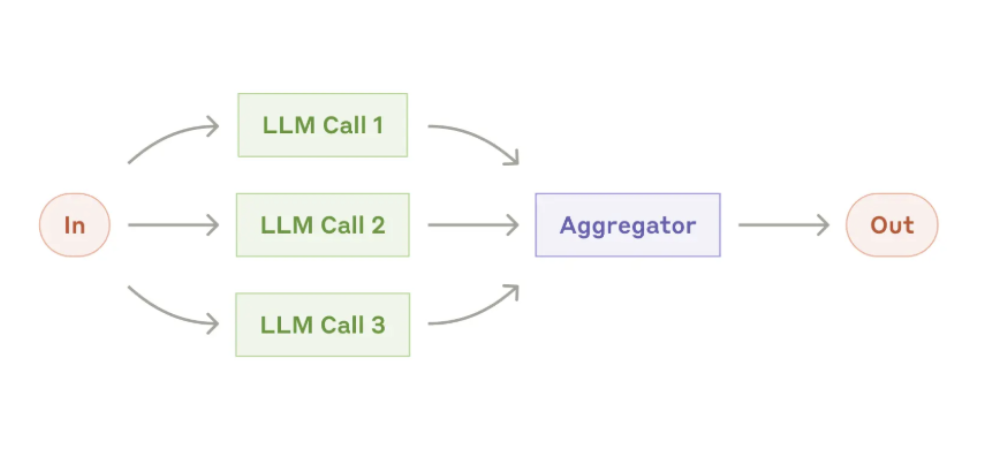

In [43]:
Image(filename='/home/cairo/code/effective-ai-agents/images/parallelization.png', width=800, height=600)

In [44]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [45]:
# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}

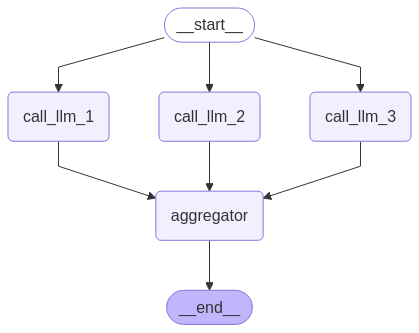

In [49]:
# Build workflow
parallel_builder = StateGraph(State)
# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)
# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")

# Compile
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_builder.compile().get_graph().draw_mermaid_png()))

In [50]:
state = parallel_workflow.invoke({"topic": "sushi"})
print(state["combined_output"])

Here's a story, joke, and poem about sushi!

STORY:
Hiroshi Sato had spent his entire life chasing the legend of the “Moonlight Tuna,” a rare fish said to glow with a pearly sheen under a full moon. Every night before dawn, he’d rise from his modest seaside home in Toyama and row his tiny boat into the fog, convinced that the perfect slice of tuna would transform him from a humble sushi chef into an artist.

One evening, as he prepared his knives by lantern light, his young apprentice Yumi sneaked into the kitchen. “Master,” she whispered, “teach me how to feel the soul of the fish.” Sato paused. He’d always worked alone— sushi craft was his sacred ritual— but something in Yumi’s eager eyes stirred his heart. He nodded once, tapped her shoulder, and promised to share his secret.

That very night, under a swollen silver moon, Sato and Yumi pushed off into silent waves. The ocean was a glass mirror, broken only by the occasional leap of a sardine. Hours passed. Yumi shivered under her co

### Routing

Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

**When to use this workflow:** Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

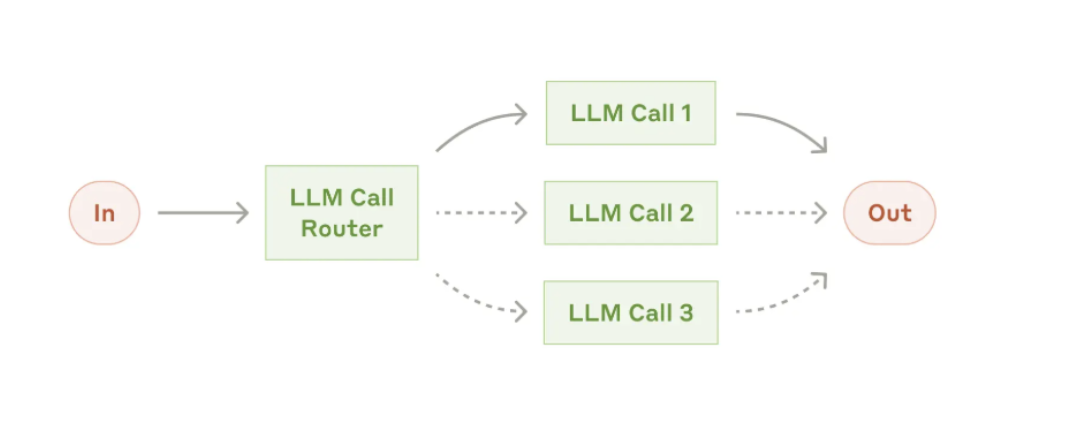

In [51]:
Image(filename='/home/cairo/code/effective-ai-agents/images/routing.png', width=800, height=600)

In [52]:
from typing_extensions import Literal

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The step to execute in the workflow"
    )

# Augment the LLM with a schema for structured output
router = llm.with_structured_output(Route)

In [53]:
# State
class State(TypedDict):
    input: str
    decision: str
    output: str

In [54]:
from langchain_core.messages import SystemMessage, HumanMessage

# Nodes
def llm_call_1(state: State):
    """Write a short story"""

    print("Write a short story")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_2(state: State):
    """Write a poem"""

    print("Write a poem")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_3(state: State):  
    """Write a joke"""

    print("Write a joke")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )
    return {"decision": decision.step}

# Conditional edge function to route to the appropriate node
def route(state: State):
    """Route the input to the appropriate node"""

    # Check the decision and return the corresponding node
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "poem":
        return "llm_call_2"
    elif state["decision"] == "joke":
        return "llm_call_3"
    else:
        raise ValueError("Invalid decision")

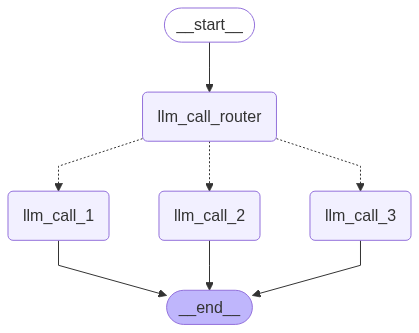

In [55]:
# Build workflow
router_builder = StateGraph(State)
# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)
# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router", route, {"llm_call_1": "llm_call_1", 
                               "llm_call_2": "llm_call_2", 
                               "llm_call_3": "llm_call_3"}
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)
# Compile
router_workflow = router_builder.compile()
# Show workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [56]:
state = router_workflow.invoke({"input": "Write a joke about dogs"})
print(state["output"])

Write a joke
Why do dogs run in circles before lying down?  
Because nobody ever taught them how to draw a straight line!


In [57]:
state = router_workflow.invoke({"input": "Write a poem about dogs"})
print(state["output"])

Write a poem
Morning light spills across eager eyes,  
A bound of energy on gentle paws—  
Each wagged tail an open invitation  
To chase the sun across dew-kissed lawns.  

Nose to earth, they chart hidden stories  
In every blade of grass and drifting breeze.  
Their joy, unguarded, teaches us to wonder  
At simple marvels others scarcely seize.  

In silent hours, they press close against our hearts,  
A warm reminder that we’re never alone.  
Their steady breath, a lullaby of comfort,  
Transforms our house into a loving home.  

When stars stitch silver paths across the sky,  
They curl in dreams of endless fields and play.  
And in that peaceful hush, we softly whisper:  
Thank you, faithful friend, for lighting our way.


In [59]:
state = router_workflow.invoke({"input": "Write a story about Yorkshire terriers"})
print(state["output"])

Write a short story
In the little town of Bramblewick, tucked between rolling green hills and stone cottages, lived two Yorkshire terriers named Poppy and Barnaby. Poppy was a sprightly three–year–old with a silky blue-and-tan coat that shimmered in the morning sun. Barnaby, a mellow five–year-old, sported an older, grayer muzzle but carried himself with the calm assurance of a seasoned traveler. Though they shared a cozy home with their owner, Miss Helena Everhart, each day felt like a grand adventure.

One crisp spring morning, Miss Everhart announced, “Today we’re hiking up to Echo Hill!” Poppy’s ears perked up and her tail wagged so fast it sounded like a tiny fan. Barnaby stretched lazily, yawning, but followed along when Poppy dashed out the door. Down the cobblestone lane they went, noses twitching at the scent of blooming bluebells and fresh grass dew.

The path to Echo Hill wound through open fields where sheep grazed under watchful Border Collies. Poppy bounded ahead, leaping

### Orchestrator-Worker

In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

**When to use this workflow:** This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

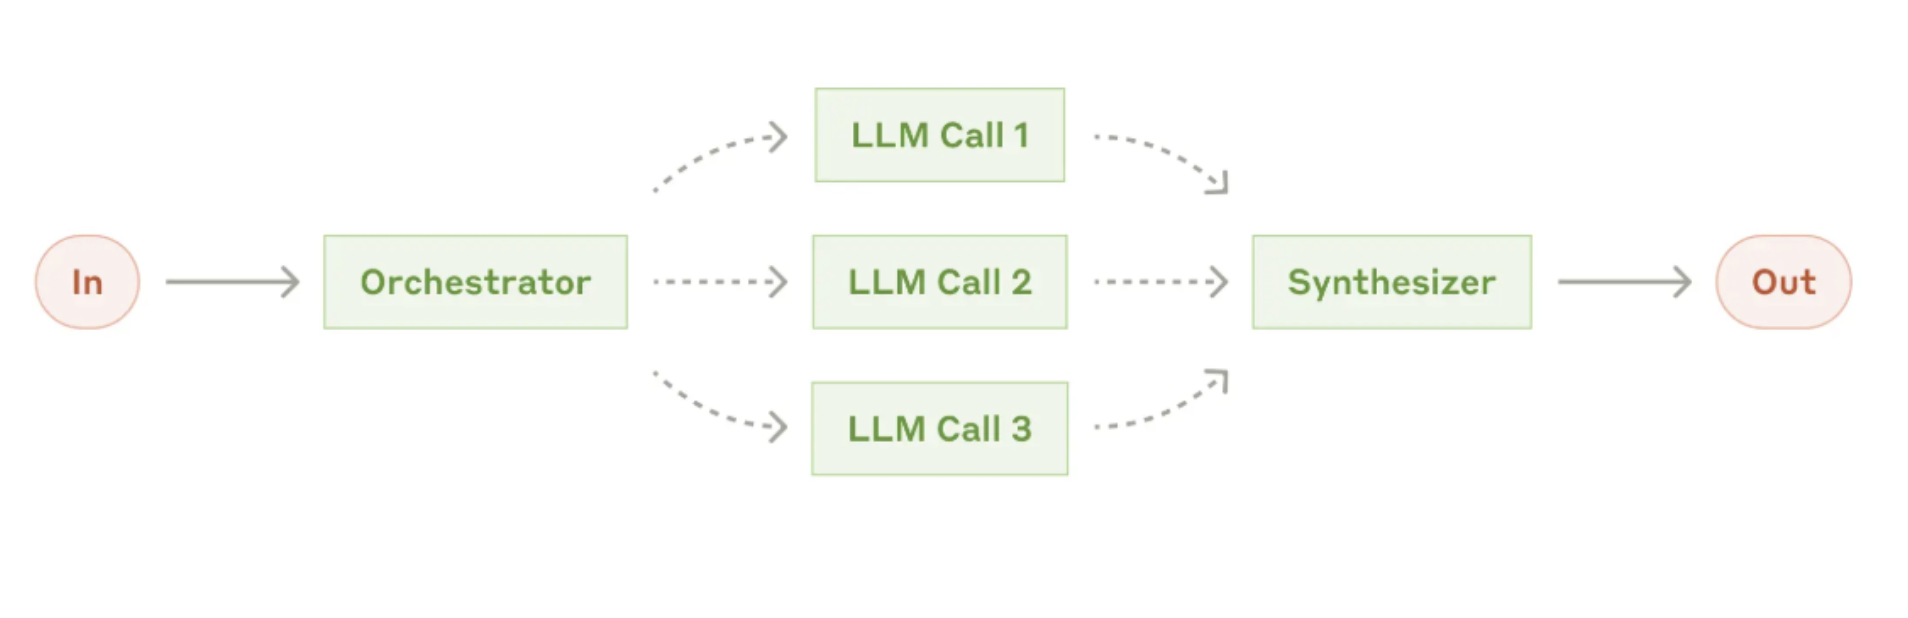

In [60]:
Image(filename='/home/cairo/code/effective-ai-agents/images/orchestrator.png', width=800, height=600)

In [61]:
from typing import Annotated, List
import operator

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="The name of the section of the report"
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section."
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections to be included in the report."
    )

# Augment the LLM with a schema for structured output
planner = llm.with_structured_output(Sections)

In [62]:
# Graph state
class State(TypedDict):
    topic: str
    sections: List[Section]
    completed_sections: Annotated[
        list, operator.add
    ] # All workers write to this key in parallel
    final_report: str # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add] # All workers write to this key in parallel

In [72]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Plan a report on the topic."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )
    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker that generates a section of the report"""

    # Generate report section
    section = llm.invoke(
        [
            SystemMessage(content="Write a section of the report."),
            HumanMessage(content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
    )
        ]
    )
    return {"completed_sections": [section.content]}

def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

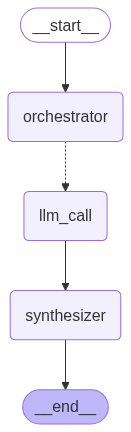

In [73]:
from langgraph.constants import Send
    
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [74]:
state = orchestrator_worker.invoke({"topic": "Create a report on atonal music"})
from IPython.display import Markdown

Markdown(state["final_report"])

Introduction to Atonal Music

Definition  
Atonal music is a style of composition in which no single pitch or tonal center dominates the harmonic and melodic structure. Unlike tonal music—where hierarchies of “home” and “away” keys shape listeners’ expectations and perceptions—atonal works deliberately avoid establishing such functional relationships. Pioneered in the early twentieth century, atonality represents a fundamental break with centuries of Western practice, in which diatonic scales and conventional harmonic progressions formed the basis of musical coherence.

Distinguishing Features  
• Absence of a tonal center: No pitch is treated as a gravitational “home”; all twelve tones of the chromatic scale are given roughly equal importance.  
• Use of dissonance as a structural element: Intervals and chords that would traditionally require resolution are instead treated as independent sonorities.  
• Non-hierarchical pitch organization: Composers often employ techniques—such as pitch‐class sets or rows—to ensure that no single note or interval predominates.  
• Fragmented melodic lines: Themes and motifs may be developed through nontraditional procedures, including permutation, inversion, and transposition, rather than conventional sequence and variation.  
• Rhythmic and textural innovation: Freed from tonal goals, composers explore novel rhythmic groupings and timbral contrasts to generate forward motion and formal coherence.

Significance in the Broader Musical Landscape  
Atonality emerged as part of a wider modernist impulse to question and transcend inherited artistic conventions. Its arrival around 1908–1910, chiefly through the work of Arnold Schoenberg and his circle (Anton Webern and Alban Berg), opened new expressive possibilities, challenging composers and audiences to rethink the nature of musical tension, release and expectation. Over the succeeding decades, atonal principles fueled the development of serialism, electronic music, and numerous avant-garde movements—each expanding the palette of compositional methods.

Beyond the concert hall, atonal techniques have influenced film scoring, contemporary jazz, experimental rock and electronic genres, demonstrating their adaptability to different aesthetic contexts. While atonality can be experienced as demanding or disorienting, its radical redefinition of harmony and form has had a lasting impact on the evolution of Western art music, marking a critical turning point between Romantic expressiveness and the pluralistic sound world of the twenty-first century.

---

Historical Context and Origins

At the turn of the twentieth century Europe was undergoing rapid artistic, intellectual, and social transformation. In music, the massive expressive canvases of late Romanticism—epitomized by Wagner’s chromatic operas and Mahler’s expansive symphonies—stretched the conventions of functional harmony almost to the breaking point. This saturation of richly colored, highly chromatic language prompted a search for new means of expression when traditional tonality no longer seemed sufficient to capture the changing sensibility of the age.

1. Late Romantic Saturation of Tonality  
  • Wagner’s “endless melody” and Mahler’s vast orchestral palette showcased chromatic progressions that blurred key centers and destabilized listeners’ expectations.  
  • French composers such as César Franck and Camille Saint-Saëns, and Russian figures like Tchaikovsky, likewise amplified harmonic tension with intricate modulations and extended chords.  
  • The result was a pervasive sense that the tonal system had been explored to its outermost limits. Critics and audiences alike began to sense that a new musical idiom might be necessary.

2. Philosophical and Aesthetic Currents  
  • The fin-de-siècle mood—marked by Symbolist poetry, Decadent literature, and the writings of Nietzsche—celebrated individual subjectivity, ambiguity, and the irrational.  
  • Visual arts were moving away from literal representation toward Impressionism and Expressionism, privileging mood, color, and psychological depth over clear narrative.  
  • These cross-disciplinary trends encouraged composers to question inherited forms and to seek music that mirrored modern life’s uncertainty and dislocation.

3. Early Modernist Experiments  
  • In France, Claude Debussy pioneered a new harmonic vocabulary based on whole-tone scales, pentatonic modes, and unresolved chords. Works like Prélude à l’après-midi d’un faune (1894) suggested that music could evoke atmosphere without relying on traditional functional progressions.  
  • In Central Europe, composers such as Alexander Scriabin pushed harmony further, using mystic chords and synthetic scales to break the gravitational pull of key centers.  
  • In Munich and Vienna, Arnold Schoenberg, Alban Berg, and Anton Webern began to articulate an “emancipation of dissonance,” moving toward atonal writing that would dispense with the hierarchy of tonic and dominant altogether.

4. Institutional and Cultural Catalysts  
  • The rise of new concert societies, publishing houses, and periodicals provided forums for avant-garde composers to share unconventional scores and theoretical writings.  
  • Educational institutions like the Vienna Academy, and salons hosted by patrons such as Kunstschau in Vienna, encouraged debate about the future of music.  
  • Audiences, while often bewildered or divided, were drawn by the promise of musical innovation that reflected the broader modernist impulse in literature, painting, and philosophy.

By 1900, the combined pressures of late Romantic excess, avant-garde aesthetic ideals, and a climate of intellectual restlessness had set the stage for a wholesale rethinking of tonality. Composers across Europe were poised to reject the inherited system of key relationships and to forge new organizational principles—an evolution that would lead directly into the serialism, neoclassicism, and experimentalism of the modern era.

---

Theoretical Foundations and Description

This section reviews the conceptual groundwork that made atonality—and its more systematic offspring, serialism—possible. We begin with Schoenberg’s early experiments in “free” atonality, proceed to his formalization of the twelve-tone technique, and then outline later abstractions in pitch-class set theory and wider serial approaches.

1. Schoenberg’s Free Atonality  
Arnold Schoenberg’s break with functional tonality around 1908–1912 marked the first sustained effort to compose without a central key. In works such as the Second String Quartet (1908) and the piano pieces of Op. 11 (1909), Schoenberg treated all twelve chromatic pitches as potential protagonists rather than subordinate scale‐degree functions. Characteristics of his free atonal style include:  
  • Avoidance of traditional cadential formulas and tonic–dominant relationships  
  • Motivic unity achieved through intervallic cells (e.g., the three-note “basic motive”)  
  • Emphasis on registral and timbral contrast rather than harmonic progression  

Although still retaining expressive gestures traceable to late Romanticism, this stage paved the way for a more rigorous ordering of pitch.

2. Twelve-Tone Technique  
In 1921 Schoenberg codified the twelve-tone (dodecaphonic) method, in which a composer constructs a prime row containing all twelve pitch-classes without repetition. The principal operations are:  
  • Prime (P): the original ordering of the 12-note series  
  • Inversion (I): mirror of the prime about its first pitch  
  • Retrograde (R): reversal of the prime sequence  
  • Retrograde-inversion (RI): reversal of the inverted row  

By selecting transpositions of these four forms, a composer ensures balanced use of the chromatic aggregate. Schoenberg’s students Alban Berg and Anton Webern further individualized the method—Berg often embedded tonal gestures within a row, while Webern pursued extreme concision and pointillistic textures.

3. Pitch-Class Set Theory  
In the 1950s and 1960s, theorists such as Milton Babbitt, Allen Forte, and Joseph Straus developed a more abstract analytical language for atonal music. Key concepts include:  
  • Pitch-class (pc): an equivalence class of all octave‐related pitches (0–11)  
  • Set class: a family of pitch-class sets related by transposition and/or inversion  
  • Prime form: the most “packed” or normalized ordering of a set class for comparison  

Using these tools, analysts could identify non‐serial atonal works’ recurring interval patterns and macrostructural designs—extending Schoenberg’s motivic ideas into a formalized, combinatorial framework.

4. Other Serial Approaches  
Beyond pitch organization, composers in the postwar avant-garde explored total serialism, applying serial procedures to parameters such as rhythm, dynamics, and articulation. Notable examples:  
  • Olivier Messiaen’s “modes of limited transposition” (impact on early serialists)  
  • Pierre Boulez’s Structures I (1952) with serialized duration and attack points  
  • Karlheinz Stockhausen’s Kreuzspiel (1951) blending pitch and rhythmic series  

These experiments demonstrated how serial principles could generate multidimensional coherence, freeing modern composers from reliance on tonal hierarchies and opening new horizons of musical structure and expression.

---

Arnold Schoenberg and the Second Viennese School

The Second Viennese School—consisting of Arnold Schoenberg and his two most prominent pupils, Alban Berg and Anton Webern—revolutionized early 20th-century music by breaking away from tonal conventions and laying the groundwork for atonal and serial composition. Each composer contributed distinctive approaches to expressionism, formal organization, and the use of the twelve-tone row, yet all shared a commitment to “emancipating dissonance” and exploring new sound worlds.

1. Arnold Schoenberg  
Contributions  
• Pioneer of free atonality (circa 1908–1921) and inventor of the twelve-tone (dodecaphonic) technique (1923).  
• Articulated theoretical foundations in essays such as “Harmonielehre” (Theory of Harmony, 1911) and “Structural Functions of Harmony” (1947).  
• Established a compositional pedagogy that influenced generations of modernists.  

Stylistic Traits  
• Expressionist intensity: wide leaps, Sprechstimme (speech-song), fragmented motifs.  
• Complex counterpoint and motivic development, often derived from a single row or cell.  
• Systematic use of tone rows to generate melody, harmony, and form in serial works.  

Seminal Works  
• Pierrot Lunaire, Op. 21 (1912): masterwork of atonality and Sprechstimme, setting Albert Giraud’s poems.  
• Suite for Piano, Op. 25 (1921–23): first fully serial work, applying a twelve-tone row to all parameters.  
• Variations for Orchestra, Op. 31 (1928): large-scale, intricate serial structure.  
• Moses und Aron (unfinished opera, 1930–32): profound dramatic exploration of theological and musical serialism.  

2. Alban Berg  
Contributions  
• Bridged Romantic expression with modernist techniques, making serialism more emotionally accessible.  
• Demonstrated how tonal references and motivic gestures can coexist with a twelve-tone framework.  

Stylistic Traits  
• Lush, late-Romantic harmony often veiled within serial structures.  
• Use of recurring leitmotifs and references to diatonic centers or traditional forms.  
• Highly expressive vocal writing, dramatic pacing, and vivid orchestration.  

Seminal Works  
• Wozzeck (1922): atonal opera employing forms derived from classical templates (passacaglia, suite), intensely psychological.  
• Lyric Suite (1926): string quartet rich in hidden tone-row permutations and cryptograms, melding emotional depth with methodical design.  
• Violin Concerto (1935): poignant twelve-tone work dedicated “To the Memory of an Angel,” blending folk-like gestures with serial integrity.  

3. Anton Webern  
Contributions  
• Advanced the most concise and refined application of serial principles, influencing post-1945 avant-garde (e.g., Darmstadt School).  
• Explored Klangfarbenmelodie (tone-color melody), distributing a single line across different instruments to emphasize timbre.  

Stylistic Traits  
• Extreme brevity and economy of means—miniatures that distill motives to their purest form.  
• Pointillistic textures: isolated notes and rests create spatial and coloristic effects.  
• Rigidly organized pitch, rhythm, dynamics, and articulation under serial control.  

Seminal Works  
• Six Bagatelles for String Quartet, Op. 9 (1911–13): early atonal sketches pointing toward later concision.  
• Five Pieces for Orchestra, Op. 10 (1911–13): radical experiments in fragmentation and color.  
• Symphony, Op. 21 (1928): large-scale work combining free atonal and serial passages, exemplary of mature style.  
• Variations for Orchestra, Op. 30 (1940): advanced twelve-tone variation structure with meticulous orchestration.  

Together, Schoenberg, Berg, and Webern reshaped Western art music by forging new compositional systems, expressive idioms, and timbral possibilities. Their collective legacy endures through the vast spectrum of mid- and late-20th-century music—serialism, electronic music, and beyond—testifying to the profound impact of the Second Viennese School.

---

Section 3: Analysis of Key Works

In this section we apply analytical tools from set theory, motivic analysis, and formal archetypes to three canonical atonal pieces.  We show how pitch‐class operations, cell‐based motivic growth, and large-scale formal trajectories combine to generate coherence without a tonal center.

3.1 Arnold Schoenberg, Pierrot Lunaire, “Nacht” (Op. 21, no. 8)  
• Form and Large-Scale Trajectory: “Nacht” unfolds in a five‐section arch (A–B–C–B′–A′).  Each outer A section (mm.1–16 and 49–64) frames identical motivic material at a transposition a tritone apart, while inner B and B′ sections invert that material around pitch-class 6.  The central C (mm.25–48) functions as a developmental “interlude,” freely combining fragments from A and B.  
• Motivic Development: The opening motive [0,1,3] (in normal order 0–1–3) recurs in permutation—prime, inversion, and retrograde—across all sections.  For example, mm.5–6 present a retrograde [3,1,0] against a new rhythmic profile, and mm.54–56 invert that motive back into its prime form at PC-set [6,7,9].  
• Pitch Organization: Although atonal, the scene is colored by a recurring pitch‐class “center” on PC 0 (B-natural), reinforced by repeated registral returns in all statements of the prime motive.  Set‐class analysis shows that all vertical sonorities derive from 014 trichords or their “superset” 0147 tetrachord, creating local pitch‐class consistency without tonal function.

3.2 Anton von Webern, Five Movements for String Quartet, Op. 5, I. Sehr mäßig (mm.1–56)  
• Twelve‐Tone Row and Partitioning: Webern’s row in m.1—(0–11–1–10–4–8–3–9–2–7–5–6)—is symmetrical around its midpoint.  The first hexachord (0,11,1,10,4,8) is the inversional reflection of the second (3,9,2,7,5,6).  Webern deploys this combinatorial pair in three successive registral “blocks,” each 8 measures long.  
• Motivic Cells: Within each block, Webern extracts a 3-note generator (e.g. 0–11–1) and projects it in diminution, augmentation, and registral fragmentation.  In mm.9–12 the cell returns inverted (I5 form, 5–4–6) at the second‐string tuning, creating timbral contrast while preserving intervallic identity.  
• Formal Coherence: Although the movement lacks traditional phrase structure, its triple‐block design (Blocks A–B–A′) and pervasive row‐form rotations ensure proportional unity.  Set‐class intersection analysis reveals that adjacent row segments often share pitch-classes, forging subtle “anchor” regions that guide the listener through rapid textural shifts.

3.3 Alban Berg, Lyric Suite, IV. Allegro misterioso (mvt. 1, mm.1–64)  
• Hybrid Atonality and Centricity: Berg integrates tonal allusions (a recurring “E-major” sonority) into an otherwise twelve‐tone fabric.  The opening theme outlines an E–G♯–B triad over an [0,4,7] triad, but immediately disperses these tones into a row‐derived hexachord.  
• Formal Arch and Mirror Structure: The first 32 measures present an exposition of three row-forms (P0, R0, I5), each lasting roughly ten bars; the next 32 bars reverse that sequence (I5, R0, P0), creating a rotating arch.  Berg’s use of palindromic carets in the cello line at m.16 and m.48 highlights this symmetry.  
• Motivic and Intervallic Cohesion: A five-note cell [0,2,5,7,9] pervades the movement—in the first violin at m.2, in fragmentation in mm.10–12, and in retrograde in mm.42–44—binding exposition to recapitulation.  Interval‐class frequency charts confirm that ic 2 and ic 5 dominate, giving the texture a distinctive “minor-third” hue even absent a tonic triad.  

Taken together, these three analyses illustrate how atonal composers weld rigorous pitch‐class operations to motivic and formal designs, achieving coherence without tonal hierarchy.  Set‐class methods, row matrices, and motivic cell tracking provide systematic paths through music that eschews traditional tonality yet retains compelling unity.

---

Performance Practice and Interpretation

Performing atonal repertoire presents distinct technical and musical challenges that require both meticulous preparation and imaginative interpretive solutions. The absence of a governing tonal center, complex rhythmic structures, and often unorthodox notation demand robust strategies for accuracy, cohesion, and communicative clarity—both within the ensemble and toward the listener.

1. Practical Challenges  
• Pitch‐and‐Interval Accuracy: Without tonal gravity to guide intonation, players must rely on precise score study, frequent tuning checks (especially in small ensembles), and the use of reference pitches (e.g. electronic tuners or fixed‐pitch instruments) during rehearsal.  
• Rhythmic Complexity: Irregular meters, intricate tuplets, and metric modulation call for slow, subdivided practice and—where possible—a click track or conductor’s steady beat. Reinforcing internal pulse through vocal counting or group clapping can also help internalize asymmetrical patterns.  
• Memory and Notation Density: Large atonal scores often feature dense cluster chords and non‐standard notation (graphic elements, microtones). Segmenting the music into digestible cells or rhythmic motives and annotating the score with rehearsal letters, fingerings, or cue cross‐references reduces cognitive load.

2. Interpretive Strategies  
• Motivic and Structural Analysis: Identifying recurring pitch‐class sets, intervallic cells, or registral juxtapositions allows performers to shape phrases coherently. Emphasizing these building blocks through slight dynamic shading or articulation contrasts creates perceptual landmarks for both players and listeners.  
• Articulation and Color: In lieu of tonal tension–release arcs, performers can create expressive trajectory through varied attack types (hard vs. soft articulations), bowing choices (sul ponticello vs. sul tasto), or breath weight. Timbral differentiation highlights formal divisions and can substitute for traditional phrasing cues.  
• Dynamic Profile and Register: Atonal works often exploit wide register leaps. Mapping a dynamic “contour line” that mirrors pitch height—e.g. crescendos into upper registers, diminuendos into low tessituras—imposes an overarching shape that counterbalances tonal ambiguity.

3. Ensemble Coordination  
• Vision and Gesture: Frequent eye contact and clear preparatory gestures are vital when metrical accents shift unpredictably. Wind or brass players may adopt exaggerated breathing cues; string players can use visible bow lifts or left‐hand motions to signal cut‐offs.  
• Conductor as Anchor: Even in conductorless groups, rotating a “time‐keeper” for particularly labyrinthine passages can ensure unified tempo transitions. When a conductor is present, minimizing excessive baton motion keeps focus on micro‐rhythmic precision.  
• Rehearsal Hierarchy: Begin with individual lines at a slow tempo, then pair players for duets or partial textures before full ensemble runs. This “layered” approach allows communication of intonation and rhythm in smaller groups, speeding integration into the larger texture.

4. Addressing Listener Perception  
• Contextual Framing: Short pre‐concert talks or program notes that outline the work’s pitch organization, motives, or rhetorical design equip audiences with listening “handles.”  
• Signposting Through Repetition: Where composers repeat row fragments or rhythmic cells, performers can subtly heighten contrast—by lengthening the final note, injecting a breath, or isolating a chord—to draw attention to these structural anchors.  
• Spatial and Visual Elements: Stage layout (e.g. semi–circle vs. straight line) and visual uniformity (matching attire or stand lights) help frame the performance as a coherent event, focusing audience attention on collective sonority rather than individual unpredictability.

By combining rigorous score preparation with deliberate expressive choices—supported by strategic rehearsal techniques and audience engagement—performers can negotiate the practical hurdles of atonal repertoire and deliver interpretations that are both technically secure and meaningfully communicative.

---

Reception, Criticism, and Controversy

From its first stirrings in early twentieth-century Vienna through to its reappraisal in the twenty-first century, atonal music has provoked some of the fiercest debates in Western art music. Critics and audiences have alternately decried it as unintelligible noise or hailed it as the embodiment of musical freedom. This section surveys the arc of those responses, examining how arguments over accessibility, aesthetic value, and cultural impact have evolved over more than a century.

1. Early Reactions: 1908–1930  
●   Initial shock and scandal.  Arnold Schoenberg’s Piano Suite, Op. 25 (1921–23) and his earlier Five Orchestral Pieces, Op. 16 (1909) were met by many critics with bewilderment. Reviewers in Vienna and Berlin sometimes dismissed these works as “deranged” or “pointless”—the public, accustomed to late-Romantic tonality, often walked out of premieres.  
●   Defenses from the avant-garde.  Hugo von Hofmannsthal, Alban Berg, and Anton Webern championed Schoenberg as a visionary, arguing in letters and manifestoes that atonality freed music from outdated harmonic constraints. Their writings framed the break with tonality as an intellectual necessity rather than a mere provocation.  
●   Institutional backlash.  Concert programming committees and radio broadcasters frequently labeled atonal pieces “unbroadcastable,” limiting public exposure. In places like conservative Munich or London, local ensembles omitted atonal works for years, ensuring that the style remained controversial even among professional musicians.

2. Mid-Century Criticism: 1930–1960  
●   Intellectualist versus populist camps.  Theodor W. Adorno’s essays positioned Schoenberg’s atonal and serial music as the pinnacle of modernist truth, contrasting it with formulaic “entertainment music.” In direct opposition, critics such as Virgil Thomson and Aaron Copland argued that serious music must maintain a dialogue with general audiences, warning that the new language risked alienating listeners entirely.  
●   Cultural and political inflection.  Under the Nazi regime, atonal and serial composers were labeled “degenerate,” their works banned and performances condemned. In the United States after World War II, American composers and institutions (the “Darmstadt School” and its sponsors) embraced serialism as a symbolic rejection of totalitarianism—yet this association further politicized the debate, making aesthetic judgments inseparable from ideological stances.  
●   Pedagogical tensions.  As music schools incorporated atonal theory into their curricula, a new generation of composers was divided between staunch serialists and those who rejected strict twelve-tone procedures. The rift fueled polemical articles in journals such as Perspectives of New Music and Tempo, each side accusing the other of stagnation or dilution of the avant-garde.

3. Accessibility and Aesthetic Value: 1960–2000  
●   Accusations of elitism.  Critics on the left and right alike sometimes portrayed atonal music as an elitist project, accessible only to those with specialized training. Concert promoters noted dwindling audiences, and some academic commentators suggested that the music’s perceived impenetrability threatened the very survival of contemporary classical performance.  
●   Rebuttals and diversifications.  Composers like George Crumb, Elliott Carter, and György Ligeti blended atonal techniques with more familiar gestures—extended instrumental colors, quasi-tonal passages, or even popular-music motifs—to argue for a “new expressivity.” Their successes in attracting wider audiences demonstrated that atonality need not exclude emotional engagement.  
●   Popular culture intersections.  Film and television scores by Bernard Herrmann, Jerry Goldsmith, and later Hans Zimmer employed clusters, atonal textures, and serial procedures to evoke tension, horror, or otherworldliness. These applications familiarized broader audiences with atonal sounds, albeit outside the concert hall.

4. Contemporary Reappraisal and Ongoing Controversies: 2000–Present  
●   Scholarly reassessment.  Musicologists have revisited early critical dismissals in light of newly available letters, sketches, and recordings. Studies now emphasize the expressive logic of atonal works, their structural rigor, and their connections to broader artistic movements (Expressionism, Surrealism, etc.).  
●   Audience engagement strategies.  Programming innovations—pre‐concert talks, multimedia presentations, and community workshops—have aimed to demystify atonality. While some critics view these efforts as necessary outreach, others question whether they risk oversimplifying complex music.  
●   Diversity and inclusion debates.  As the classical-music world reckons with questions of representation, atonal music’s status is being reexamined: whose voices were heard in its early development, and how might non-Western or historically marginalized composers have contributed parallel radical languages? This inquiry has broadened controversies beyond mere sonic accessibility to issues of cultural equity and historiography.

Conclusion  
Atonal music’s reception history is one of extremes—exultation and denunciation, marginalization and rediscovery. Its controversies over accessibility and aesthetic worth have never been fully resolved, even as its influence permeates film, academia, and contemporary composition. The ongoing dialogue reflects a larger tension at the heart of modern art: whether the primary function of music is to comfort and please or to challenge and transform.

---

Legacy and Contemporary Developments

In the decades since Schoenberg, Berg, and Webern articulated the principles of atonality and the twelve-tone method, these ideas have continued to resonate through multiple trajectories of musical innovation. Atonality’s initial break from tonal hierarchy opened doors to new ways of organizing pitch, timbre, and form—an impact that can be traced in three main areas: the post-war avant-garde, the rise of electronic and computer music, and the pluralistic landscape inhabited by many contemporary composers.

1. Post-War Avant-Garde  
After World War II, European and American composers sought radical means of extending Schoenberg’s revolution. At the Darmstadt summer courses, figures such as Pierre Boulez and Karlheinz Stockhausen adopted and expanded serial principles, applying rigorous control not only to pitch but to rhythm, dynamics, and timbre (“total serialism”). Meanwhile, Milton Babbitt in the United States explored serial organization by computer, demonstrating how atonality could be integrated with emerging digital technologies. Even John Cage—while rejecting certain dogmas of twelve-tone technique—owed a conceptual debt to atonality’s emphasis on structural coherence outside of traditional tonal centers.  
• Boulez’s Structures I (1952) exemplifies point-series manipulation taken beyond twelve tones.  
• Stockhausen’s Gruppen (1955–57) distributes twelve-tone materials among three orchestras to dissolve conventional temporal and spatial hierarchies.  

2. Electronic Music and Technological Innovation  
Atonal thinking found a natural partner in electronic sound generation. Early studios in Cologne, Paris, and Milan turned to tape splicing, frequency modulation, and ring modulation as tools for exploring new pitch relations unconstrained by conventional instruments. Luigi Russolo’s intuitions about “noise” (1920s) matured into musique concrète in Paris, where Pierre Henry and Pierre Schaeffer assembled fragments of recorded sound according to non-tonal logics. In the 1960s and ’70s, synthesizer pioneers like Morton Subotnick and Pauline Oliveros used voltage-controlled oscillators and live electronic feedback to craft atonal soundscapes with unprecedented precision. Later developments in digital signal processing and interactive programming environments (Max/MSP, SuperCollider) ensured that atonality could continue evolving in real time, responsive to performer gestures and audience interaction.

3. Contemporary Composers and Musical Pluralism  
Today’s composers often merge atonal strategies with a spectrum of historical and vernacular influences. Rather than pursuing a single “school,” many artists embrace eclecticism—drawing on spectral techniques, microtonality, improvisation, and non-Western modalities side by side with twelve-tone or point-series procedures.  
• Kaija Saariaho employs spectral harmonies alongside serialized pitch cells.  
• Unsuk Chin combines rhythmic serialization with electronic processing to create shimmering textures.  
• George Lewis integrates algorithmic composition and Afro-futurist improvisation, shifting atonal methods into new cultural contexts.

Role in Musical Pluralism  
Atonality’s true legacy may lie less in strict adherence to Schoenberg’s original rules and more in its demonstration that musical coherence need not depend on traditional functional harmony. In today’s pluralistic environment, atonal techniques provide one among many tools for structuring sound. Composers, improvisers, and sound artists freely borrow, hybridize, and subvert these methods—affirming that the radical break of the early twentieth century remains a living, adaptable catalyst for continued exploration.

---

Conclusion and Future Directions

In this report we have traced the evolution of atonal music from its early 20th-century origins through successive theoretical and practical developments.  Key insights include:
•  The fundamental break with tonal hierarchy, as championed by Schoenberg and his students, opened new expressive territories.  
•  Set-theoretical and serial techniques provided rigorous organizational tools, but also invited more fluid, post-serial approaches (e.g. combinatoriality, transformational theory).  
•  Analytic methods built around pitch-class sets, intervallic networks and voice-leading graphs revealed hidden structures in seemingly free atonal textures.  
•  Composers and performers continually negotiate the balance between formal control and spontaneous gesture—an aesthetic tension that remains central to atonal creativity.  
•  Emerging computational and algorithmic methods are reshaping how we model, generate and hear atonal materials, offering new forms of interactivity and exploration.

Looking ahead, several promising avenues invite further inquiry and experimentation:

1. Expanded Theoretical Frameworks  
   – Development of multidimensional models that integrate pitch, rhythm, timbre and space.  
   – Hybrid approaches combining set theory with spectral, microtonal or non-Western pitch systems.

2. Interdisciplinary and Cross-Cultural Projects  
   – Comparative studies of atonality alongside folk, world or electronic musics to uncover novel hybrid vocabularies.  
   – Collaborations between composers, visual artists, dancers and technologists to create immersive, multimedia atonal works.

3. Computational and Generative Innovation  
   – Machine-learning systems trained on atonal repertoires for real-time composition and performance support.  
   – Interactive installations and networked environments that respond dynamically to performer input or audience presence.

4. Cognitive and Perceptual Research  
   – Psychoacoustic experiments on listener perception of atonal structures, dissonance and expectancy.  
   – Neuroscientific studies examining how the brain processes atonal versus tonal patterns.

5. Pedagogy and Outreach  
   – New educational tools—software, apps and game-based platforms—to make atonal concepts more accessible.  
   – Community workshops and public-performance series that demystify atonality and foster broader engagement.

By pursuing these directions, theorists, composers and performers can continue to expand the expressive frontiers of atonal music, ensuring its relevance and vitality for decades to come.

### Evaluator-optimizer

In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

**When to use this workflow:** This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.


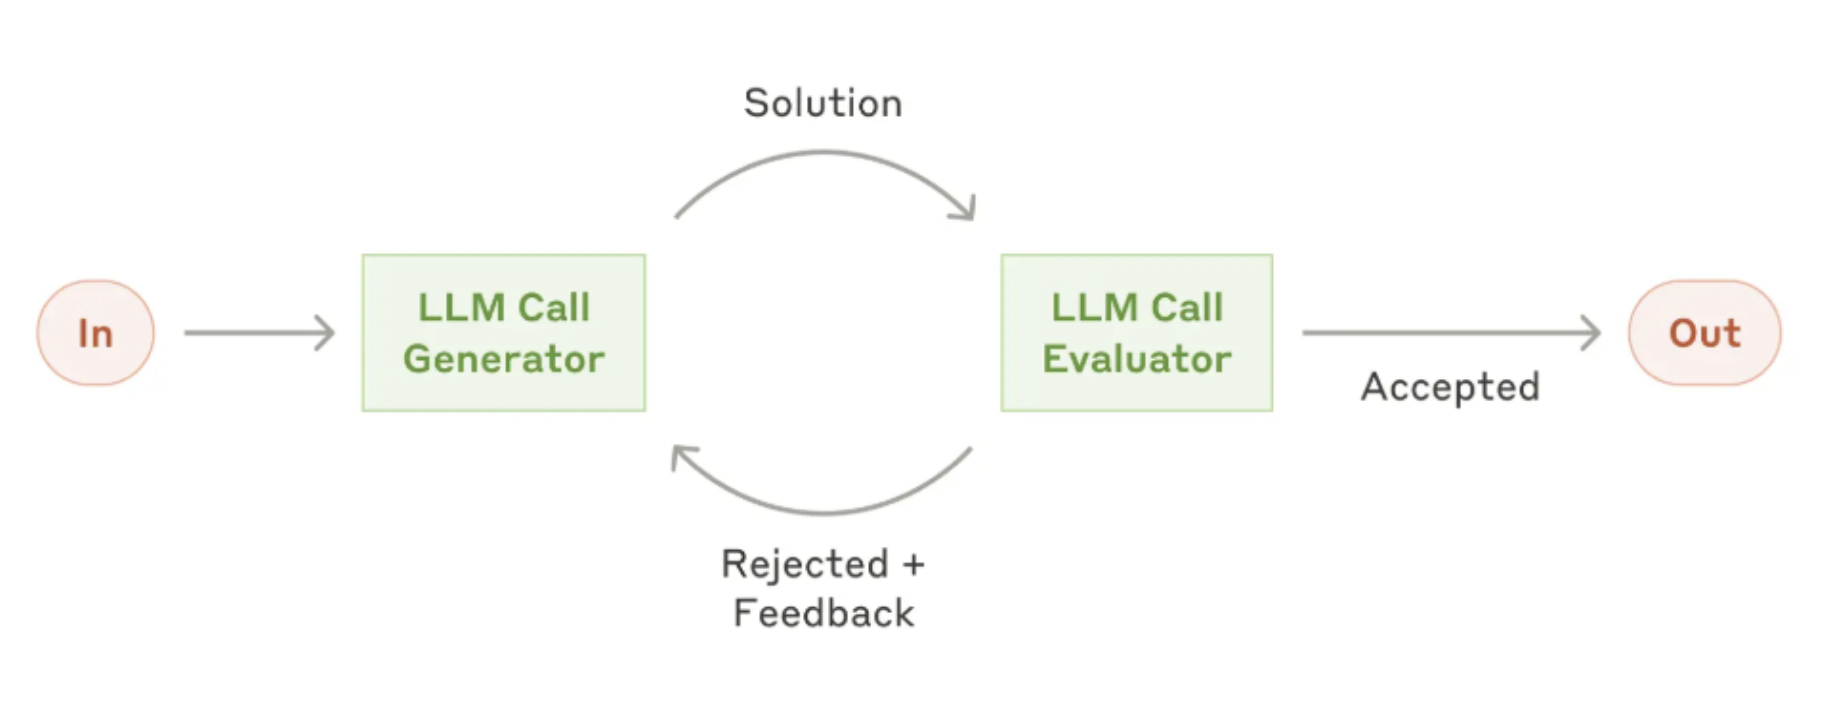

In [75]:
Image(filename='/home/cairo/code/effective-ai-agents/images/evaluator-optimizer.png', width=800, height=600)

In [77]:
# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not"
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it."
   )
    
# Augment the LLM with a schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [78]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [79]:
# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

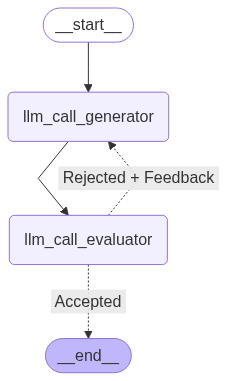

In [80]:
# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [81]:
state = optimizer_workflow.invoke({"topic": "Bats"})
print(state["joke"])

Why are bats such great baseball players?  
Because they always come with their own bat!


### Agent

Agents plan, take actions (via tool-calling), and respond to feedback (in a loop).

Agents can handle sophisticated tasks, but their implementation is often straightforward. They are typically just LLMs using tools based on environmental feedback in a loop. It is therefore crucial to design toolsets and their documentation clearly and thoughtfully.

**When to use agents:** Agents can be used for open-ended problems where it’s difficult or impossible to predict the required number of steps, and where you can’t hardcode a fixed path. The LLM will potentially operate for many turns, and you must have some level of trust in its decision-making. Agents' autonomy makes them ideal for scaling tasks in trusted environments.

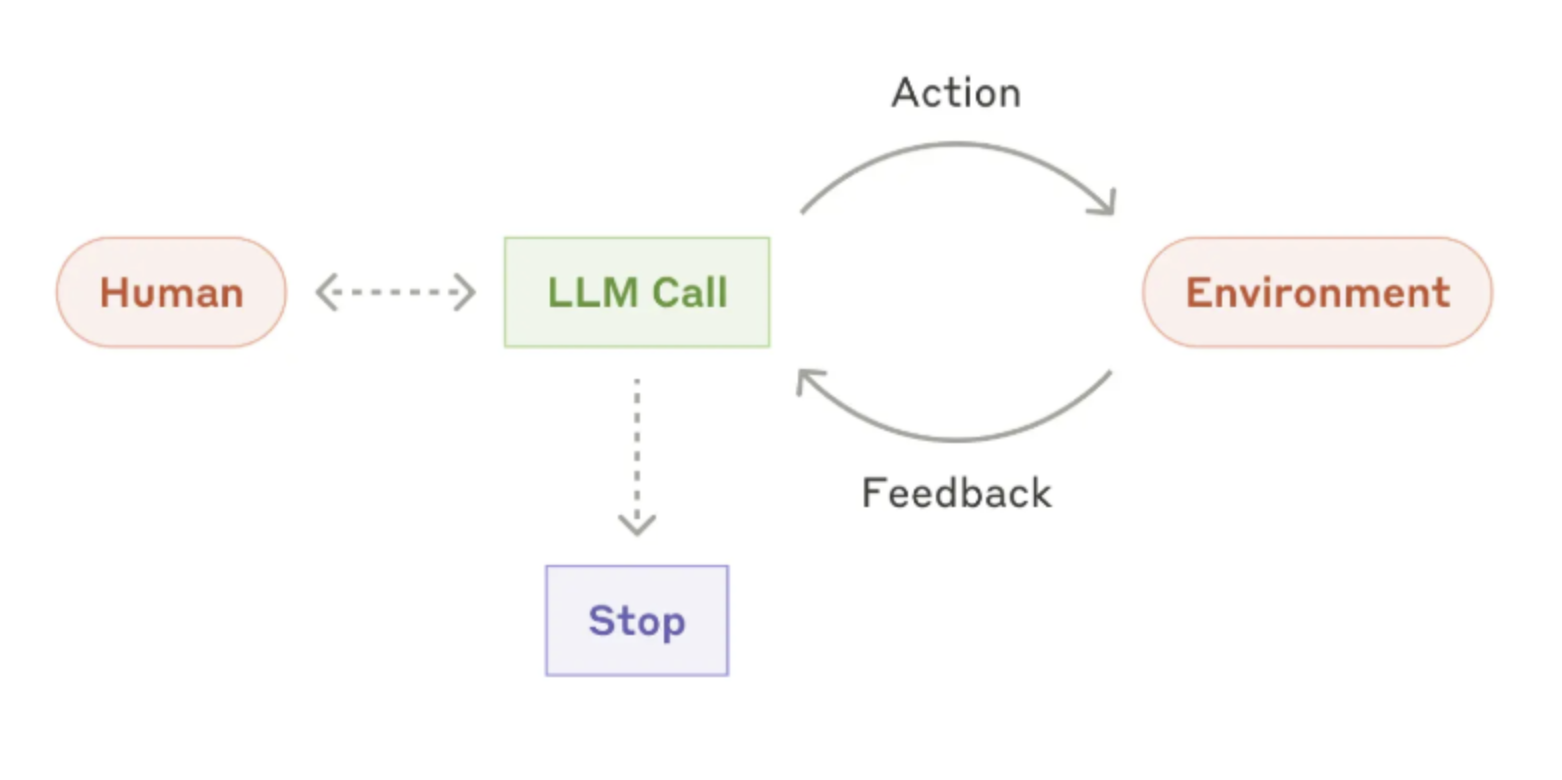

In [82]:
Image(filename='/home/cairo/code/effective-ai-agents/images/agent.png', width=800, height=600)

In [83]:
from langchain_core.tools import tool

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [84]:
from langgraph.graph import MessagesState
from langchain_core.messages import ToolMessage

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

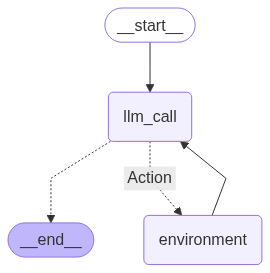

In [85]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [86]:
messages = [HumanMessage(content="Add 3 and 4. Then, take the output and multiple by 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Then, take the output and multiple by 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_BvbckcGYx6VV7EBv72SlpoKo)
 Call ID: call_BvbckcGYx6VV7EBv72SlpoKo
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_NeYs3GTVZjueWXIRPrDfw8ru)
 Call ID: call_NeYs3GTVZjueWXIRPrDfw8ru
  Args:
    a: 7
    b: 4
================================= Tool Message =================================

28
================================== Ai Message ==================================

First, 3 + 4 = 7.  
Then, 7 × 4 = 28.
